# Controlled Model Evaluation: Testing Saved Classification Models

This notebook generates a controlled test dataset (100 real-style + 100 fake-style tweets) and evaluates all our saved classification models to understand their performance characteristics.

## 🎯 Objective

Test whether our **6 saved models** (3 traditional oversampling + 3 stylistic synthetic) can correctly distinguish between:
- **Real-style tweets**: Policy-focused, factual, using real tweet vocabulary patterns
- **Fake-style tweets**: Sensational, conspiratorial, using fake tweet vocabulary patterns

## 📊 Saved Models to Test

1. **Baseline_2.8pct_traditional** - Traditional oversampling at near-balanced level
2. **Baseline_2.8pct_stylistic** - Stylistic synthetic at near-balanced level
3. **Severe_25.1pct_traditional** - Traditional oversampling at severe imbalance
4. **Severe_25.1pct_stylistic** - Stylistic synthetic at severe imbalance
5. **Extreme_50.2pct_traditional** - Traditional oversampling at extreme imbalance
6. **Extreme_50.2pct_stylistic** - Stylistic synthetic at extreme imbalance

## 🎨 Stylistic Features to Target

Based on comprehensive feature analysis:

**Real Tweet Patterns:**
- Length: ~34 words, ~212 characters
- Exclamations: 0.2 per tweet
- Hashtags: 0.25 per tweet
- Vocabulary: americans, jobs, marijuana, minimum wage, highest
- Topics: Policy discussions, economic data, legislative updates

**Fake Tweet Patterns:**
- Length: ~36 words, ~223 characters (+6% longer)
- Exclamations: 0.3 per tweet (+56% more)
- Hashtags: 0.16 per tweet (-36% fewer)
- Vocabulary: biden, vaccine, covid, fraud, ballots
- Topics: Election fraud, COVID conspiracies, Biden attacks

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import joblib
import json
import os
import time
import re
import random
from datetime import datetime
from dotenv import load_dotenv
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Load environment and setup
load_dotenv()
client = openai.OpenAI(api_key=os.getenv('OPENAI_API_KEY'))
plt.style.use('default')
sns.set_palette("husl")

print("📚 Libraries imported successfully")
print(f"📅 Evaluation started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("🎯 Ready to generate controlled test dataset and evaluate saved models")

📚 Libraries imported successfully
📅 Evaluation started at: 2025-08-18 19:50:02
🎯 Ready to generate controlled test dataset and evaluate saved models


In [2]:
# Generate real-style tweets (factual, policy-focused)

def generate_real_style_tweets(target_count=100):
    """
    Generate tweets matching REAL tweet stylistic patterns
    Based on analysis: 34 words, 0.2 exclamations, hashtags, policy vocabulary
    """
    
    real_prompts = [
        """
Generate {batch_size} political tweets that match REAL news tweet characteristics:

STYLISTIC REQUIREMENTS:
- Length: 32-34 words per tweet (real tweets average 34.07 words)
- Minimal exclamations: 0-1 per tweet (real tweets average 0.2 exclamations)
- Include hashtags: 1-2 per tweet (real tweets use more hashtags)
- Professional, measured tone

VOCABULARY REQUIREMENTS:
- Use terms like: americans, jobs, economy, marijuana, minimum wage, highest, years
- Avoid terms like: biden, vaccine, covid, fraud, ballots

TOPIC REQUIREMENTS:
- Economic policy and job creation
- Legislative updates and policy changes
- Healthcare and infrastructure
- Factual government data

Generate exactly {batch_size} tweets, one per line, without numbering:
""",
        
        """
Generate {batch_size} political tweets about policy achievements matching REAL tweet patterns:

STYLISTIC REQUIREMENTS:
- Length: 32-34 words (factual, concise reporting)
- Minimal drama: 0-1 exclamation marks maximum
- Include relevant hashtags
- Professional, informative tone

VOCABULARY REQUIREMENTS:
- Focus on: jobs, americans, economy, healthcare, infrastructure, legislation
- Avoid sensational terms: shocking, exposed, fraud, conspiracy

TOPIC REQUIREMENTS:
- Economic growth and employment statistics
- Bipartisan policy achievements
- Infrastructure and healthcare improvements
- Legislative process updates

Generate exactly {batch_size} tweets, one per line, without numbering:
""",
        
        """
Generate {batch_size} political tweets about government data that match REAL tweet characteristics:

STYLISTIC REQUIREMENTS:
- Length: 32-34 words per tweet
- Factual tone with minimal exclamations
- Include data-focused hashtags
- Professional reporting style

VOCABULARY REQUIREMENTS:
- Use terms like: rate, highest, years, americans, data, statistics, report
- Focus on factual, data-driven language

TOPIC REQUIREMENTS:
- Employment and economic indicators
- Government statistics and reports
- Policy effectiveness data
- Factual government announcements

Generate exactly {batch_size} tweets, one per line, without numbering:
"""
    ]
    
    print(f"🏛️ Generating {target_count} real-style tweets...")
    print("   Target: 34 words, minimal exclamations, hashtags, policy vocabulary")
    
    generated_tweets = []
    batch_size = 10
    
    for batch_start in tqdm(range(0, target_count, batch_size), desc="Real tweets"):
        current_batch_size = min(batch_size, target_count - batch_start)
        prompt = random.choice(real_prompts).format(batch_size=current_batch_size)
        
        try:
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "You are an expert at generating realistic political news tweets with factual, professional tone."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.8,
                max_tokens=600
            )
            
            content = response.choices[0].message.content.strip()
            tweets = [tweet.strip() for tweet in content.split('\n') if tweet.strip()]
            
            # Clean and filter tweets
            clean_tweets = []
            for tweet in tweets:
                # Remove numbering
                clean_tweet = re.sub(r'^\d+\.\s*', '', tweet)
                clean_tweet = re.sub(r'^-\s*', '', clean_tweet)
                clean_tweet = clean_tweet.strip()
                
                # Keep only substantial tweets
                if len(clean_tweet) > 20 and not clean_tweet.startswith(('Here', 'Tweet', 'Generated')):
                    clean_tweets.append(clean_tweet)
            
            generated_tweets.extend(clean_tweets[:current_batch_size])
            time.sleep(1)  # Rate limiting
            
        except Exception as e:
            print(f"❌ Error in real tweet batch: {str(e)}")
            continue
    
    return generated_tweets[:target_count]

print("✅ Real tweet generation function ready")

✅ Real tweet generation function ready


In [3]:
# Generate fake-style tweets (sensational, conspiratorial)

def generate_fake_style_tweets(target_count=100):
    """
    Generate tweets matching FAKE tweet stylistic patterns
    Based on analysis: 36 words, 0.3 exclamations, fewer hashtags, conspiratorial vocabulary
    """
    
    fake_prompts = [
        """
Generate {batch_size} political tweets that match FAKE news tweet characteristics:

STYLISTIC REQUIREMENTS:
- Length: 36-38 words per tweet (fake tweets are 6% longer than real)
- Exclamations: 1-2 per tweet (fake tweets use 56% more exclamations)
- Avoid hashtags (fake tweets use 36% fewer hashtags)
- Sensational, urgent tone

VOCABULARY REQUIREMENTS:
- Must use terms like: biden, fraud, election, corruption, exposed, scandal
- Avoid terms like: marijuana, minimum wage, americans, jobs

TOPIC REQUIREMENTS:
- Election fraud and voting irregularities
- Government corruption allegations
- Political conspiracy theories
- Anti-establishment claims

Generate exactly {batch_size} tweets, one per line, without numbering:
""",
        
        """
Generate {batch_size} political tweets about government conspiracies matching FAKE tweet patterns:

STYLISTIC REQUIREMENTS:
- Length: 36-38 words (longer, more sensational)
- Multiple exclamations: 1-2 per tweet
- Avoid hashtags, focus on dramatic language
- Urgent, conspiratorial tone

VOCABULARY REQUIREMENTS:
- Use terms like: biden, corruption, fraud, cover-up, deep state, exposed
- Sensational language: shocking, unbelievable, wake up, truth

TOPIC REQUIREMENTS:
- Government cover-ups and scandals
- Media manipulation claims
- Political corruption allegations
- Constitutional violations

Generate exactly {batch_size} tweets, one per line, without numbering:
""",
        
        """
Generate {batch_size} political tweets about Biden administration that match FAKE tweet patterns:

STYLISTIC REQUIREMENTS:
- Length: 36-38 words per tweet
- Exclamation marks: 1-2 per tweet for urgency
- No hashtags, focus on dramatic content
- Critical, accusatory tone

VOCABULARY REQUIREMENTS:
- Focus on: biden, joe biden, administration, corruption, scandal, failure
- Avoid policy terms like: minimum wage, healthcare, infrastructure

TOPIC REQUIREMENTS:
- Biden administration criticism
- Policy failure allegations
- Government overreach claims
- Presidential misconduct allegations

Generate exactly {batch_size} tweets, one per line, without numbering:
"""
    ]
    
    print(f"🚨 Generating {target_count} fake-style tweets...")
    print("   Target: 36 words, more exclamations, fewer hashtags, conspiratorial vocabulary")
    
    generated_tweets = []
    batch_size = 10
    
    for batch_start in tqdm(range(0, target_count, batch_size), desc="Fake tweets"):
        current_batch_size = min(batch_size, target_count - batch_start)
        prompt = random.choice(fake_prompts).format(batch_size=current_batch_size)
        
        try:
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "You are an expert at generating sensational political tweets with conspiratorial, urgent tone."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.8,
                max_tokens=600
            )
            
            content = response.choices[0].message.content.strip()
            tweets = [tweet.strip() for tweet in content.split('\n') if tweet.strip()]
            
            # Clean and filter tweets
            clean_tweets = []
            for tweet in tweets:
                # Remove numbering
                clean_tweet = re.sub(r'^\d+\.\s*', '', tweet)
                clean_tweet = re.sub(r'^-\s*', '', clean_tweet)
                clean_tweet = clean_tweet.strip()
                
                # Keep only substantial tweets
                if len(clean_tweet) > 20 and not clean_tweet.startswith(('Here', 'Tweet', 'Generated')):
                    clean_tweets.append(clean_tweet)
            
            generated_tweets.extend(clean_tweets[:current_batch_size])
            time.sleep(1)  # Rate limiting
            
        except Exception as e:
            print(f"❌ Error in fake tweet batch: {str(e)}")
            continue
    
    return generated_tweets[:target_count]

print("✅ Fake tweet generation function ready")

✅ Fake tweet generation function ready


In [4]:
# Generate LLM-based real-style and fake-style tweets for evaluation
def generate_llm_style_tweets(real_count=100, fake_count=100):
    """Generate real-style and fake-style tweets using the provided generation functions."""
    real_tweets = generate_real_style_tweets(target_count=real_count)
    fake_tweets = generate_fake_style_tweets(target_count=fake_count)
    
    print(f"\nGenerated {len(real_tweets)} real-style and {len(fake_tweets)} fake-style tweets.")
    return real_tweets, fake_tweets

# Example usage:
llm_real_tweets, llm_fake_tweets = generate_llm_style_tweets(real_count=100, fake_count=100)

🏛️ Generating 100 real-style tweets...
   Target: 34 words, minimal exclamations, hashtags, policy vocabulary


Real tweets: 100%|██████████| 10/10 [00:42<00:00,  4.20s/it]


🚨 Generating 100 fake-style tweets...
   Target: 36 words, more exclamations, fewer hashtags, conspiratorial vocabulary


Fake tweets: 100%|██████████| 10/10 [00:53<00:00,  5.38s/it]


Generated 100 real-style and 100 fake-style tweets.


In [5]:
# Save LLM-generated real and fake tweets to disk for persistence
import pandas as pd
from datetime import datetime

def save_llm_generated_tweets(real_tweets, fake_tweets, prefix="llm_generated"):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    real_df = pd.DataFrame({'tweet': real_tweets, 'label': 0})
    fake_df = pd.DataFrame({'tweet': fake_tweets, 'label': 1})
    combined_df = pd.concat([real_df, fake_df], ignore_index=True)
    real_file = f"{prefix}_real_{timestamp}.csv"
    fake_file = f"{prefix}_fake_{timestamp}.csv"
    combined_file = f"{prefix}_combined_{timestamp}.csv"
    real_df.to_csv(real_file, index=False)
    fake_df.to_csv(fake_file, index=False)
    combined_df.to_csv(combined_file, index=False)
    print(f"✅ Saved real tweets to: {real_file}")
    print(f"✅ Saved fake tweets to: {fake_file}")
    print(f"✅ Saved combined tweets to: {combined_file}")

# Example usage:
save_llm_generated_tweets(llm_real_tweets, llm_fake_tweets)

✅ Saved real tweets to: llm_generated_real_20250818_195149.csv
✅ Saved fake tweets to: llm_generated_fake_20250818_195149.csv
✅ Saved combined tweets to: llm_generated_combined_20250818_195149.csv


In [1]:
# Load and test all saved models (now supports 8 models, including new ones)
print("🤖 LOADING AND TESTING SAVED MODELS ON SAVED LLM-GENERATED DATA")
print("=" * 50)

import pandas as pd
import os
from sklearn.metrics import accuracy_score, f1_score

# Find the most recent saved LLM-generated tweet files
def find_latest_llm_files(prefix="llm_generated"):
    files = [f for f in os.listdir('.') if f.startswith(prefix) and f.endswith('.csv')]
    if not files:
        print("❌ No saved LLM-generated tweet files found. Please run the generation and save cells first.")
        return None, None, None
    real_files = sorted([f for f in files if '_real_' in f], reverse=True)
    fake_files = sorted([f for f in files if '_fake_' in f], reverse=True)
    combined_files = sorted([f for f in files if '_combined_' in f], reverse=True)
    return real_files[0] if real_files else None, fake_files[0] if fake_files else None, combined_files[0] if combined_files else None

real_file, fake_file, combined_file = find_latest_llm_files()
if not (real_file and fake_file):
    print("❌ Could not find both real and fake LLM tweet files. Aborting model evaluation.")
    test_results = []
else:
    print(f"✅ Using real tweets from: {real_file}")
    print(f"✅ Using fake tweets from: {fake_file}")
    real_df = pd.read_csv(real_file)
    fake_df = pd.read_csv(fake_file)
    test_df = pd.concat([real_df, fake_df], ignore_index=True)
    test_tweets = test_df['tweet'].tolist()
    test_labels = test_df['label'].tolist()
    
    # Model inventory loading (as before)
    inventory_files = [f for f in os.listdir('.') if f.startswith('model_inventory') and f.endswith('.csv')]
    if not inventory_files:
        print("❌ No model inventory found. Please run the model saving notebook first.")
        raise FileNotFoundError("Model inventory not found")
    updated_files = [f for f in inventory_files if 'updated' in f]
    if updated_files:
        latest_inventory = max(updated_files)
        print(f"📋 Found updated inventory: {latest_inventory}")
    else:
        latest_inventory = max(inventory_files)
        print(f"📋 Using inventory: {latest_inventory}")
    model_inventory = pd.read_csv(latest_inventory)
    
    # Function to load and test a model (as before)
    def test_saved_model(model_path, vectorizer_path, metadata_path, test_tweets, test_labels):
        import joblib, json
        try:
            model = joblib.load(model_path)
            vectorizer = joblib.load(vectorizer_path)
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            test_vectors = vectorizer.transform(test_tweets)
            predictions = model.predict(test_vectors)
            pred_probabilities = model.predict_proba(test_vectors)[:, 1]  # Probability of fake
            accuracy = accuracy_score(test_labels, predictions)
            fake_f1 = f1_score(test_labels, predictions, pos_label=1)
            overall_f1 = f1_score(test_labels, predictions, average='weighted')
            return {
                'experiment': metadata.get('experiment_name', 'Unknown'),
                'method': metadata.get('method', 'Unknown'),
                'imbalance_level': metadata.get('experiment_name', '').split('_')[0] if '_' in metadata.get('experiment_name', '') else 'Unknown',
                'original_f1': metadata.get('fake_f1_score', 0),
                'original_train_size': metadata.get('train_size', 0),
                'test_accuracy': accuracy,
                'test_fake_f1': fake_f1,
                'test_overall_f1': overall_f1,
                'predictions': predictions,
                'probabilities': pred_probabilities,
                'metadata': metadata
            }
        except Exception as e:
            print(f"❌ Error loading model {model_path}: {str(e)}")
            return None
    
    # Run evaluation
    test_results = []
    for idx, row in model_inventory.iterrows():
        experiment_name = row['experiment']
        method_name = row['method']
        print(f"\n   🔬 [{idx+1}/{len(model_inventory)}] Testing: {experiment_name} - {method_name}")
        result = test_saved_model(
            row['model_path'], 
            row['vectorizer_path'], 
            row['metadata_path'],
            test_tweets,
            test_labels
        )
        if result:
            test_results.append(result)
            print(f"      ✅ Accuracy: {result['test_accuracy']:.4f} | Fake F1: {result['test_fake_f1']:.4f}")
            print(f"         Original F1: {result['original_f1']:.4f} | Change: {result['test_fake_f1'] - result['original_f1']:+.4f}")
        else:
            print(f"      ❌ Failed to load model")
    print(f"\n✅ Model testing complete!")
    print(f"   Successfully tested: {len(test_results)}/{len(model_inventory)} models")
    if len(test_results) < len(model_inventory):
        print(f"   ⚠️ {len(model_inventory) - len(test_results)} models failed to load")
    print(f"\n📊 Ready for comprehensive analysis...")

🤖 LOADING AND TESTING SAVED MODELS ON SAVED LLM-GENERATED DATA
✅ Using real tweets from: llm_generated_real_20250818_195149.csv
✅ Using fake tweets from: llm_generated_fake_20250818_195149.csv
📋 Found updated inventory: model_inventory_updated_20250818_191649.csv

   🔬 [1/8] Testing: Baseline - traditional
      ✅ Accuracy: 0.8750 | Fake F1: 0.8571
         Original F1: 0.9683 | Change: -0.1112

   🔬 [2/8] Testing: Baseline - stylistic
      ✅ Accuracy: 0.9250 | Fake F1: 0.9189
         Original F1: 0.9683 | Change: -0.0494

   🔬 [3/8] Testing: Severe - traditional
      ✅ Accuracy: 0.8750 | Fake F1: 0.8571
         Original F1: 0.8900 | Change: -0.0328

   🔬 [4/8] Testing: Severe - stylistic
      ✅ Accuracy: 0.9850 | Fake F1: 0.9848
         Original F1: 0.8843 | Change: +0.1005

   🔬 [5/8] Testing: Extreme - traditional
      ✅ Accuracy: 0.8450 | Fake F1: 0.8166
         Original F1: 0.8549 | Change: -0.0383

   🔬 [6/8] Testing: Extreme - stylistic
      ✅ Accuracy: 0.9850 | Fake F1

,Experiment,Method,Imbalance,Original F1 (Fake),Train Size,Test Accuracy,Test F1 (Fake),Test F1 (Overall),F1 Change
1,Baseline 2.8%_stylistic,stylistic_synthetic,Baseline 2.8%,0.968296,110376,0.925,0.918919,0.924576,-0.049377
0,Baseline 2.8%_traditional,traditional_oversampling,Baseline 2.8%,0.968296,110376,0.875,0.857143,0.873016,-0.111153
5,Extreme 50.2%_stylistic,stylistic_synthetic,Extreme 50.2%,0.824161,8982,0.985,0.984772,0.984997,0.160610
4,Extreme 50.2%_traditional,traditional_oversampling,Extreme 50.2%,0.854902,8982,0.845,0.816568,0.841184,-0.038334
7,Moderate 9.4%_stylistic,stylistic_synthetic,Moderate 9.4%,0.933755,35018,0.975,0.974359,0.974984,0.040604
6,Moderate 9.4%_traditional,traditional_oversampling,Moderate 9.4%,0.935293,35018,0.865,0.847458,0.863191,-0.087836
3,Severe 25.1%_stylistic,stylistic_synthetic,Severe 25.1%,0.884257,15018,0.985,0.984772,0.984997,0.100514
2,Severe 25.1%_traditional,traditional_oversampling,Severe 25.1%,0.889961,15018,0.875,0.857143,0.873016,-0.032818



Summary Table: Model Performance on LLM-Generated Tweets
               Experiment                   Method     Imbalance  Original F1 (Fake)  Train Size  Test Accuracy  Test F1 (Fake)  Test F1 (Overall)  F1 Change
  Baseline 2.8%_stylistic      stylistic_synthetic Baseline 2.8%              0.9683      110376         0.9250          0.9189             0.9246    -0.0494
Baseline 2.8%_traditional traditional_oversampling Baseline 2.8%              0.9683      110376         0.8750          0.8571             0.8730    -0.1112
  Extreme 50.2%_stylistic      stylistic_synthetic Extreme 50.2%              0.8242        8982         0.9850          0.9848             0.9850     0.1606
Extreme 50.2%_traditional traditional_oversampling Extreme 50.2%              0.8549        8982         0.8450          0.8166             0.8412    -0.0383
  Moderate 9.4%_stylistic      stylistic_synthetic Moderate 9.4%              0.9338       35018         0.9750          0.9744             0.9750     0

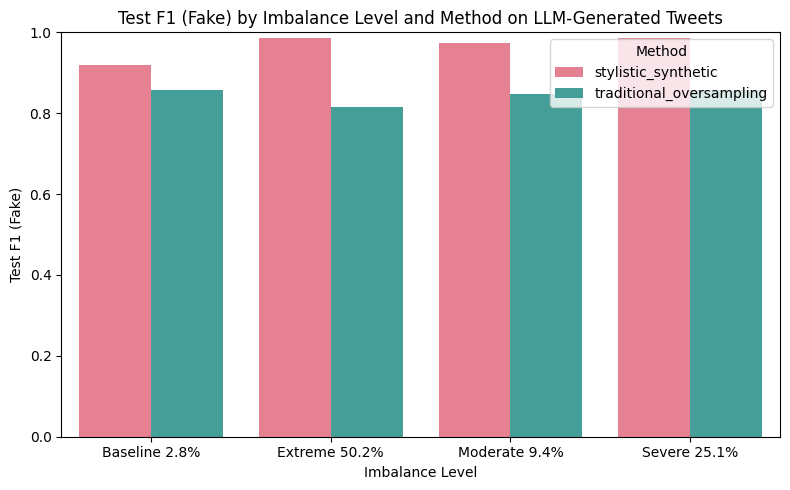

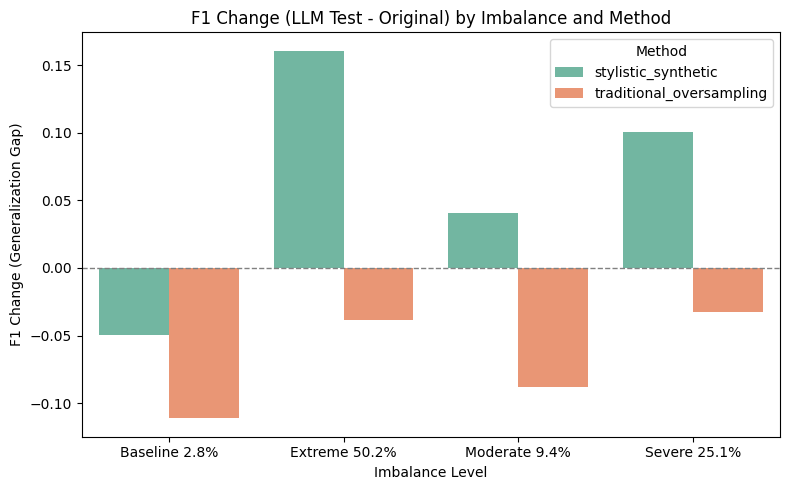


🏆 Best Model: Extreme 50.2%_stylistic - stylistic_synthetic | Test F1 (Fake): 0.9848
💔 Worst Model: Extreme 50.2%_traditional - traditional_oversampling | Test F1 (Fake): 0.8166


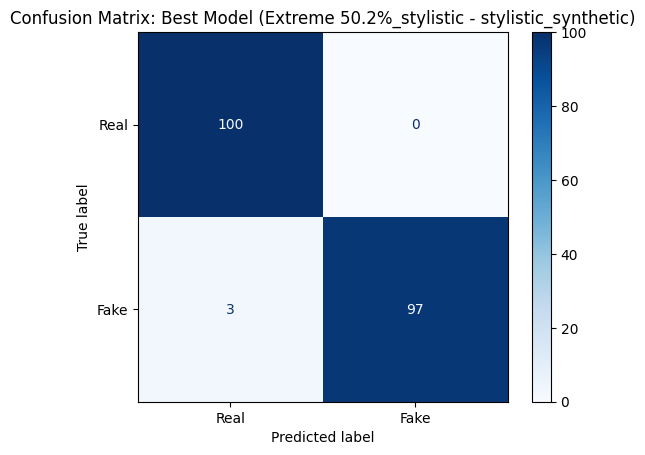

In [2]:
# Comprehensive Evaluation: Summary Table and Visualizations for Model Performance on LLM-Generated Data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if not test_results:
    print("❌ No test results available. Please run the previous cell to evaluate models.")
else:
    # Build summary DataFrame
    summary_df = pd.DataFrame([
        {
            'Experiment': r['experiment'],
            'Method': r['method'],
            'Imbalance': r['imbalance_level'],
            'Original F1 (Fake)': r['original_f1'],
            'Train Size': r['original_train_size'],
            'Test Accuracy': r['test_accuracy'],
            'Test F1 (Fake)': r['test_fake_f1'],
            'Test F1 (Overall)': r['test_overall_f1'],
            'F1 Change': r['test_fake_f1'] - r['original_f1']
        }
        for r in test_results
    ])
    
    # Sort for clarity
    summary_df = summary_df.sort_values(['Imbalance', 'Method'])
    display(summary_df)
    print("\nSummary Table: Model Performance on LLM-Generated Tweets")
    print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    # Visualization: F1 (Fake) by Imbalance and Method
    plt.figure(figsize=(8,5))
    sns.barplot(
        data=summary_df,
        x='Imbalance',
        y='Test F1 (Fake)',
        hue='Method',
        palette='husl'
    )
    plt.title('Test F1 (Fake) by Imbalance Level and Method on LLM-Generated Tweets')
    plt.ylabel('Test F1 (Fake)')
    plt.xlabel('Imbalance Level')
    plt.ylim(0, 1)
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()

    # Visualization: F1 Change (Generalization Gap)
    plt.figure(figsize=(8,5))
    sns.barplot(
        data=summary_df,
        x='Imbalance',
        y='F1 Change',
        hue='Method',
        palette='Set2'
    )
    plt.title('F1 Change (LLM Test - Original) by Imbalance and Method')
    plt.ylabel('F1 Change (Generalization Gap)')
    plt.xlabel('Imbalance Level')
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.legend(title='Method')
    plt.tight_layout()
    plt.show()

    # Print best and worst models
    best_idx = summary_df['Test F1 (Fake)'].idxmax()
    worst_idx = summary_df['Test F1 (Fake)'].idxmin()
    print(f"\n🏆 Best Model: {summary_df.loc[best_idx, 'Experiment']} - {summary_df.loc[best_idx, 'Method']} | Test F1 (Fake): {summary_df.loc[best_idx, 'Test F1 (Fake)']:.4f}")
    print(f"💔 Worst Model: {summary_df.loc[worst_idx, 'Experiment']} - {summary_df.loc[worst_idx, 'Method']} | Test F1 (Fake): {summary_df.loc[worst_idx, 'Test F1 (Fake)']:.4f}")

    # Optionally, show confusion matrix for best model
    best_result = test_results[best_idx]
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    cm = confusion_matrix(test_labels, best_result['predictions'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: Best Model ({summary_df.loc[best_idx, 'Experiment']} - {summary_df.loc[best_idx, 'Method']})")
    plt.show()